In [2]:
from nbimports import *

In [3]:
import nbhelper
nbhelper = reload(nbhelper)

In [4]:
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=False, nb_workers=6, verbose=0)

In [5]:
users, templates, annotations, A, B = nbhelper.load_data()

# load report

In [6]:
run_uuid = "f1956943e2c54175aedac690a177c64c"

In [7]:
report, params = nbhelper.get_report_params_from_runid(run_uuid, report_name="report.csv")

<AxesSubplot:>

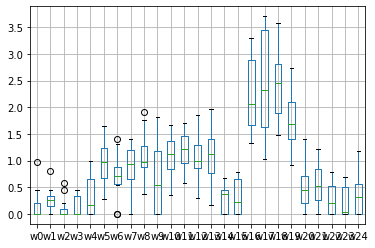

In [8]:
fig, ax = plt.subplots()
report.filter(regex="w.*").boxplot(ax=ax)

In [9]:
# fig.tight_layout()
# fig.savefig("./figs/temporal_weights_25.png")

<AxesSubplot:>

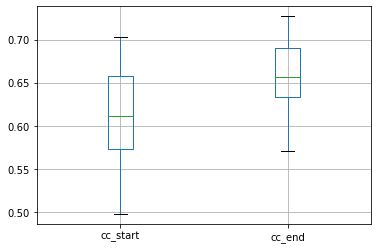

In [10]:
report[['cc_start', 'cc_end']].boxplot()

# reproduce results

In [11]:
dimensions = ['px0', 'py0', 'pz0', 'px1', 'py1', 'pz1', 'px2', 'py2', 'pz2', 'ax0', 'ay0', 'az0', 'gx0', 'gy0', 'gz0']

In [12]:
def ponderate(arr, weights):
    """Create an array of shape arr.shape[0] with weights.shape[0] equi-spaced
    segments of values weights.
    """
    n_weights = weights.shape[0]
    weights = weights.reshape(-1,1)
    region_size = arr.shape[0] // n_weights
    remainder = arr.shape[0] % n_weights
    vec = np.hstack([(weights * np.ones((n_weights, region_size))).reshape(-1),
                     weights[-1] * np.ones(remainder)])
    return vec

In [13]:
import functools
@functools.lru_cache(maxsize=2000)
def cached_compute(user, day, trial):
    """Cached compute of the DTW between a motion and a template.
    """
    a = select(users, gesture=1, user=user, day=day, trial=trial)
    a = skprep.StandardScaler().fit_transform(a[list(dimensions)])

    t = select(templates, template=1, version=0)
    t = skprep.StandardScaler().fit_transform(t[list(dimensions)])

    da, path_a = fastdtw.fastdtw(a, t, radius=10)
    path_a = np.array(path_a)
    return a, da, path_a, t

In [14]:
def compute_dtw_temporal_wrapper(weights):
    def fun(row):

#         template = select(templates, template=1, version=0)
#         a = select(users, gesture=1, user=row['user'], day=row['day_0'], trial=row['rep_0'])
#         b = select(users, gesture=1, user=row['user'], day=row['day_1'], trial=row['rep_1'])

#         # normalised position
#         a = skprep.StandardScaler().fit_transform(a[dimensions])
#         b = skprep.StandardScaler().fit_transform(b[dimensions])
#         t = skprep.StandardScaler().fit_transform(template[dimensions].iloc[100:])

#         da, path_a = fastdtw.fastdtw(a, t, radius=10)
#         db, path_b = fastdtw.fastdtw(b, t, radius=10)
#         path_a = np.array(path_a)
#         path_b = np.array(path_b)

        a, _, path_a, t = cached_compute(row['user'], row['day_0'], row['rep_0'])
        b, _, path_b, t = cached_compute(row['user'], row['day_1'], row['rep_1'])

        # ponderate
        vec = ponderate(t, np.arange(weights.shape[0]))

        da_ = np.linalg.norm( (a[path_a[:,0]] - t[path_a[:,1]]) , axis=1, ord=1)
        df = pd.DataFrame(data=np.vstack([vec[path_a[:, 1]], da_]).T, columns=['s', 'd']).astype({"s":int})
        da_ = (df.groupby("s").agg(np.sum)['d'] * weights).sum()

        db_ = np.linalg.norm( (b[path_b[:,0]] - t[path_b[:,1]]) , axis=1, ord=1)
        df = pd.DataFrame(data=np.vstack([vec[path_b[:, 1]], db_]).T, columns=['s', 'd']).astype({"s":int})
        db_ = (df.groupby("s").agg(np.sum)['d'] * weights).sum()

        row['da'] = da_
        row['db'] = db_
        row['diff'] = da_ - db_

        return row
    return fun

In [15]:
fun = compute_dtw_temporal_wrapper(np.ones(25))

In [16]:
%%time
res_org = annotations.apply(fun, axis=1)

CPU times: user 24.1 s, sys: 144 ms, total: 24.2 s
Wall time: 16.1 s


In [17]:
import sklearn.model_selection as skms

In [18]:
n_splits = int(params["cv.n_splits"])
n_repeats = int(params["cv.n_repeats"])
random_state = int(params["cv.random_state"])
rkf = skms.RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=random_state)

In [19]:
for fold_id, (train_ids, test_ids) in enumerate(rkf.split(range(12))):
    print(fold_id, (train_ids, test_ids))

0 (array([ 1,  3,  4,  6,  7, 11]), array([ 0,  2,  5,  8,  9, 10]))
1 (array([ 0,  2,  5,  8,  9, 10]), array([ 1,  3,  4,  6,  7, 11]))
2 (array([ 1,  2,  4,  5,  7, 11]), array([ 0,  3,  6,  8,  9, 10]))
3 (array([ 0,  3,  6,  8,  9, 10]), array([ 1,  2,  4,  5,  7, 11]))
4 (array([ 0,  2,  5,  8,  9, 11]), array([ 1,  3,  4,  6,  7, 10]))
5 (array([ 1,  3,  4,  6,  7, 10]), array([ 0,  2,  5,  8,  9, 11]))
6 (array([ 2,  3,  4,  6,  8, 11]), array([ 0,  1,  5,  7,  9, 10]))
7 (array([ 0,  1,  5,  7,  9, 10]), array([ 2,  3,  4,  6,  8, 11]))
8 (array([ 1,  3,  4,  8,  9, 10]), array([ 0,  2,  5,  6,  7, 11]))
9 (array([ 0,  2,  5,  6,  7, 11]), array([ 1,  3,  4,  8,  9, 10]))
10 (array([0, 1, 2, 3, 6, 7]), array([ 4,  5,  8,  9, 10, 11]))
11 (array([ 4,  5,  8,  9, 10, 11]), array([0, 1, 2, 3, 6, 7]))
12 (array([ 1,  3,  5,  8,  9, 10]), array([ 0,  2,  4,  6,  7, 11]))
13 (array([ 0,  2,  4,  6,  7, 11]), array([ 1,  3,  5,  8,  9, 10]))
14 (array([ 4,  6,  7,  8,  9, 11]), array

In [20]:
user_ids = np.array(list(set(annotations['user'])))

In [21]:
reference_train_test = []

for fold_id, (train_ids, test_ids) in enumerate(rkf.split(user_ids)):
    
    Xtrain = select(res_org.iloc[:90], user=list(user_ids[train_ids]))
    Xtest = select(res_org.iloc[:90], user=list(user_ids[test_ids]))
    r0, p = sstat.pearsonr(Xtrain['diff'], Xtrain['m'])
    r1, p = sstat.pearsonr(Xtest['diff'], Xtest['m'])

    print(fold_id, (train_ids, test_ids), "{:.2f} {:.2f}".format(r0, r1))
    
    reference_train_test.append([fold_id, r0, r1])

0 (array([ 1,  3,  4,  6,  7, 11]), array([ 0,  2,  5,  8,  9, 10])) 0.71 0.82
1 (array([ 0,  2,  5,  8,  9, 10]), array([ 1,  3,  4,  6,  7, 11])) 0.82 0.71
2 (array([ 1,  2,  4,  5,  7, 11]), array([ 0,  3,  6,  8,  9, 10])) 0.75 0.76
3 (array([ 0,  3,  6,  8,  9, 10]), array([ 1,  2,  4,  5,  7, 11])) 0.76 0.75
4 (array([ 0,  2,  5,  8,  9, 11]), array([ 1,  3,  4,  6,  7, 10])) 0.78 0.76
5 (array([ 1,  3,  4,  6,  7, 10]), array([ 0,  2,  5,  8,  9, 11])) 0.76 0.78
6 (array([ 2,  3,  4,  6,  8, 11]), array([ 0,  1,  5,  7,  9, 10])) 0.71 0.83
7 (array([ 0,  1,  5,  7,  9, 10]), array([ 2,  3,  4,  6,  8, 11])) 0.83 0.71
8 (array([ 1,  3,  4,  8,  9, 10]), array([ 0,  2,  5,  6,  7, 11])) 0.74 0.79
9 (array([ 0,  2,  5,  6,  7, 11]), array([ 1,  3,  4,  8,  9, 10])) 0.79 0.74
10 (array([0, 1, 2, 3, 6, 7]), array([ 4,  5,  8,  9, 10, 11])) 0.70 0.79
11 (array([ 4,  5,  8,  9, 10, 11]), array([0, 1, 2, 3, 6, 7])) 0.79 0.70
12 (array([ 1,  3,  5,  8,  9, 10]), array([ 0,  2,  4,  6,  7

In [22]:
reference_train_test = pd.DataFrame(reference_train_test, columns=['fold_id', 'train', 'test'])

In [23]:
reference_train_test["train"].mean()

0.759448954167206

Text(0.5, 1.0, '0.75')

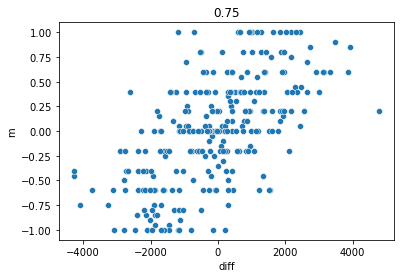

In [24]:
fig, ax = plt.subplots()
sns.scatterplot(data=res_org, x='diff', y='m', ax=ax)

r, p = sstat.pearsonr(Xtrain['diff'], Xtrain['m'])
ax.set_title("{:.2f}".format(r))

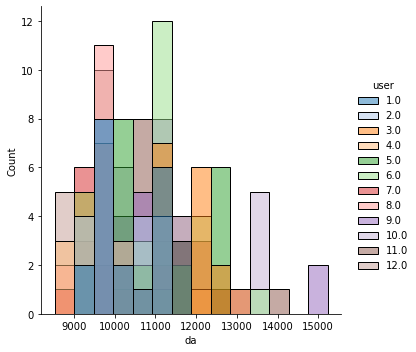

In [25]:
sns.displot(data=res_org, x="da", hue="user", palette='tab20')

In [26]:
rows = []

for fold_id, (train_ids, test_ids) in enumerate(rkf.split(user_ids)):
    print(fold_id, (train_ids, test_ids))

    Xtrain = select(res_org.iloc[:90], user=list(user_ids[train_ids]))
    Xtest = select(res_org.iloc[90:], user=list(user_ids[test_ids]))

    r0, p = sstat.pearsonr(Xtrain['diff'], Xtrain['m'])
    r1, p = sstat.pearsonr(Xtest['diff'], Xtest['m'])
    
    weights = report.iloc[fold_id].filter(regex="w.*").values
    res = annotations.parallel_apply(compute_dtw_temporal_wrapper(weights), axis=1)
    
    tmp = select(res.iloc[:90], user=list(user_ids[train_ids]))
    r2, p = sstat.pearsonr(tmp['diff'], tmp['m'])
    tmp = select(res.iloc[:90], user=list(user_ids[test_ids]))
    r3, p = sstat.pearsonr(tmp['diff'], tmp['m'])
    
    rows.append([r0, r1, r2, r3])

0 (array([ 1,  3,  4,  6,  7, 11]), array([ 0,  2,  5,  8,  9, 10]))
1 (array([ 0,  2,  5,  8,  9, 10]), array([ 1,  3,  4,  6,  7, 11]))
2 (array([ 1,  2,  4,  5,  7, 11]), array([ 0,  3,  6,  8,  9, 10]))
3 (array([ 0,  3,  6,  8,  9, 10]), array([ 1,  2,  4,  5,  7, 11]))
4 (array([ 0,  2,  5,  8,  9, 11]), array([ 1,  3,  4,  6,  7, 10]))
5 (array([ 1,  3,  4,  6,  7, 10]), array([ 0,  2,  5,  8,  9, 11]))
6 (array([ 2,  3,  4,  6,  8, 11]), array([ 0,  1,  5,  7,  9, 10]))
7 (array([ 0,  1,  5,  7,  9, 10]), array([ 2,  3,  4,  6,  8, 11]))
8 (array([ 1,  3,  4,  8,  9, 10]), array([ 0,  2,  5,  6,  7, 11]))
9 (array([ 0,  2,  5,  6,  7, 11]), array([ 1,  3,  4,  8,  9, 10]))
10 (array([0, 1, 2, 3, 6, 7]), array([ 4,  5,  8,  9, 10, 11]))
11 (array([ 4,  5,  8,  9, 10, 11]), array([0, 1, 2, 3, 6, 7]))
12 (array([ 1,  3,  5,  8,  9, 10]), array([ 0,  2,  4,  6,  7, 11]))
13 (array([ 0,  2,  4,  6,  7, 11]), array([ 1,  3,  5,  8,  9, 10]))
14 (array([ 4,  6,  7,  8,  9, 11]), array

<AxesSubplot:>

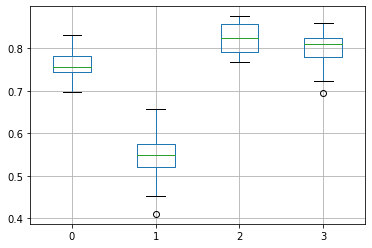

In [27]:
pd.DataFrame(rows).boxplot()

In [28]:
data = pd.DataFrame(rows, columns=['a', 'b', 'c', 'd'])

In [29]:
pg.ttest(data['a'], data['c'])

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-5.110862,30,two-sided,0.000017,"[-0.09, -0.04]",1.806962,973.714,0.998566


In [30]:
pg.ttest(data['a'], data['d'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.054233,15,two-sided,0.057809,"[-0.07, 0.0]",0.8994,1.344,0.91914


In [31]:
pg.ttest(data['a'], data['d'], paired=False)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-2.543888,30,two-sided,0.016352,"[-0.07, -0.01]",0.8994,3.507,0.692112


In [32]:
data['a'].mean(), data['d'].mean()

(0.759448954167206, 0.7959861410773746)

In [33]:
(data['d'].mean() - data['a'].mean()) / data['a'].mean()

0.048110128679068935

In [34]:
data['a'].std(), data['d'].std()

(0.037538838144161396, 0.04349074280761291)

# sweep of n_regions

In [35]:
experiment_id = "14"

In [36]:
mc = mlflow.tracking.MlflowClient(tracking_uri="../../mlruns")

In [37]:
datas=[]
for run_info in mc.list_run_infos(experiment_id):
    run = mc.get_run(run_info.run_id)
    metrics = run.data.metrics
    params = run.data.params
    data = {**{'run_id':run_info.run_id}, **params, **metrics}   
    datas.append(data)
df = pd.DataFrame(datas)

In [38]:
df.head()

,run_id,dtw.average,dtw.radius,n_region,savgol.polyorder,cross_validation,opt.n_regions,cv.test_size,opt.n_iter,preprocessing.derivatives,...,annotations,cv.n_repeats,data.normalise,cc_start,cc_all,diff_rel,cc_init,cc_end,p-value,power
0,e0dec2a01c4d414f82dc4c52c2c1138e,True,10,80,3,True,"[2, 5, 7, 12, 15, 20, 25, 30, 40, 50, 80]",0.5,10,2,...,all,8,True,0.610857,0.139610,0.057159,0.179683,0.645773,0.058092,0.478983
1,059df555027e4bd981cb0ad24fbb3558,True,10,50,3,True,"[2, 5, 7, 12, 15, 20, 25, 30, 40, 50, 80]",0.5,10,2,...,all,8,True,0.610857,0.141078,0.067892,0.179683,0.652330,0.021820,0.648562
2,44ec8851c1da4153a8f6f33468b9559a,True,10,40,3,True,"[2, 5, 7, 12, 15, 20, 25, 30, 40, 50, 80]",0.5,10,2,...,all,8,True,0.610857,0.142426,0.069794,0.179683,0.653491,0.018903,0.670641
3,fe91c1dc790f4a599eba1491c3365fb0,True,10,30,3,True,"[2, 5, 7, 12, 15, 20, 25, 30, 40, 50, 80]",0.5,10,2,...,all,8,True,0.610857,0.143040,0.082973,0.179683,0.661542,0.006514,0.807739
4,f1956943e2c54175aedac690a177c64c,True,10,25,3,True,"[2, 5, 7, 12, 15, 20, 25, 30, 40, 50, 80]",0.5,10,2,...,all,8,True,0.610857,0.144661,0.076565,0.179683,0.657627,0.010143,0.756613


In [39]:
%%time
rows = []

for i, run_info in enumerate(mc.list_run_infos(experiment_id)):
    report, params = nbhelper.get_report_params_from_runid(run_info.run_id, report_name="report.csv")
    
    print(i, run_info.run_id)
    
    for fold_id, (train_ids, test_ids) in enumerate(rkf.split(user_ids)):

        weights = report.iloc[fold_id].filter(regex="w.*").values
        res = annotations.parallel_apply(compute_dtw_temporal_wrapper(weights), axis=1)

        tmp = select(res.iloc[:90], user=list(user_ids[train_ids]))
        r2, p = sstat.pearsonr(tmp['diff'], tmp['m'])
        tmp = select(res.iloc[:90], user=list(user_ids[test_ids]))
        r3, p = sstat.pearsonr(tmp['diff'], tmp['m'])

        rows.append([params['n_region'], fold_id, r2, r3])

0 e0dec2a01c4d414f82dc4c52c2c1138e
1 059df555027e4bd981cb0ad24fbb3558
2 44ec8851c1da4153a8f6f33468b9559a
3 fe91c1dc790f4a599eba1491c3365fb0
4 f1956943e2c54175aedac690a177c64c
5 46c081cada534f47ae8bd4cb6170e924
6 7109951ce0a04d6baaf9b38571183fff
7 9583c595c70a494190a8616ebe1c5f9b
8 1c243c05580b4093a82e496a70f96780
9 53f7661ed28946fda2cecafcdc7f7baf
10 2519e36cd7a1412ca8d3811bc429b311
CPU times: user 2.35 s, sys: 8.87 s, total: 11.2 s
Wall time: 55.5 s


In [40]:
df = pd.DataFrame(data=rows, columns=['n_region', 'fold_id', 'train', 'test'])
df['n_region'] = df['n_region'].astype(int)

In [41]:
df

,n_region,fold_id,train,test
0,80,0,0.781024,0.837660
1,80,1,0.898794,0.741871
2,80,2,0.793386,0.817545
3,80,3,0.876932,0.703029
4,80,4,0.872163,0.787890
...,...,...,...,...
171,2,11,0.790273,0.697478
172,2,12,0.748898,0.753821
173,2,13,0.753807,0.749148
174,2,14,0.760800,0.748578


In [42]:
N = len(mc.list_run_infos(experiment_id))
M = n_splits * n_repeats

In [43]:
df['ref'] = np.repeat(reference_train_test['test'].values, N).reshape(M, -1).T.reshape(-1)

In [44]:
df

,n_region,fold_id,train,test,ref
0,80,0,0.781024,0.837660,0.823775
1,80,1,0.898794,0.741871,0.707412
2,80,2,0.793386,0.817545,0.756364
3,80,3,0.876932,0.703029,0.749269
4,80,4,0.872163,0.787890,0.762423
...,...,...,...,...,...
171,2,11,0.790273,0.697478,0.696727
172,2,12,0.748898,0.753821,0.753829
173,2,13,0.753807,0.749148,0.748528
174,2,14,0.760800,0.748578,0.747053


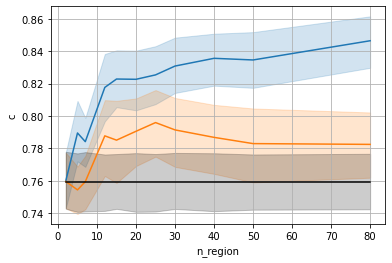

In [43]:
fig, ax = plt.subplots()
sns.lineplot(data=df, x='n_region', y='train', ax=ax)
sns.lineplot(data=df, x='n_region', y='test', ax=ax)
sns.lineplot(data=df, x='n_region', y='ref', color='black', ax=ax)
ax.set_ylabel("c")
ax.grid()

In [44]:
df_melt = df.melt(id_vars=['n_region', 'fold_id'], value_vars=['ref', 'test', 'train'])

In [45]:
df_melt.groupby(['n_region', 'variable'])['value'].mean().reset_index()

,n_region,variable,value
0,2,ref,0.759449
1,2,test,0.759656
2,2,train,0.760002
3,5,ref,0.759449
4,5,test,0.754458
5,5,train,0.789562
6,7,ref,0.759449
7,7,test,0.759553
8,7,train,0.784211
9,12,ref,0.759449


In [46]:
data = df_melt.assign(dataset=df_melt["variable"].map({"ref": "reference", "train": "training", "test":"testing"}))

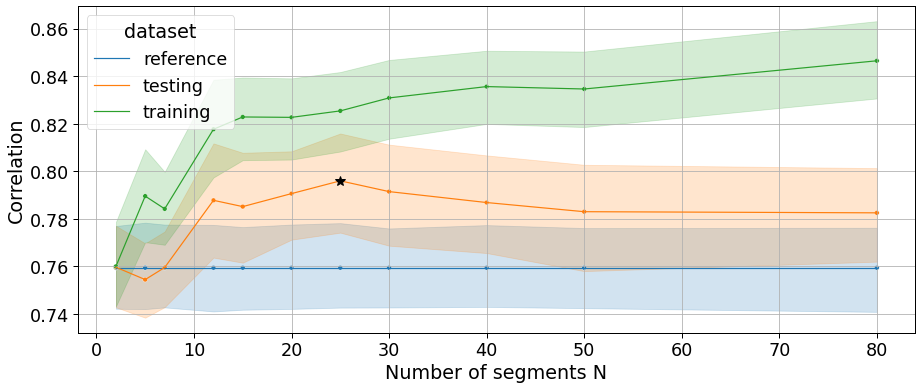

In [47]:
sns.set_context("paper", font_scale=2)

fig, ax = plt.subplots(figsize=(15, 6))
sns.lineplot(data=data, x='n_region', y='value', hue='dataset', ax=ax)

sns.scatterplot(data = df_melt.groupby(['n_region', 'variable'])['value'].mean().reset_index(),
                x='n_region', y='value', hue='variable', ax=ax, legend=False)

ax.set_ylabel("Correlation")
ax.set_xlabel("Number of segments N")


X_star = 25
y_star = df.groupby('n_region')['test'].mean().max()
ax.plot(X_star, y_star, color='k', marker="*", ms='10')

ax.grid()

In [48]:
fig.tight_layout()
fig.savefig("./figs/temporal_n_region.pdf")